# Лабораторная работа №4
## Васильев А.Р ИУ5-24М

### Цель лабораторной работы: изучение разработки рекомендательных моделей.

### Требования к отчету:
#### Отчет по лабораторной работе должен содержать:

- титульный лист;
- описание задания;
- текст программы;
- экранные формы с примерами выполнения программы.

### Задание:
- Выбрать произвольный набор данных (датасет), предназначенный для построения рекомендательных моделей.
- Опираясь на материалы лекции, сформировать рекомендации для одного пользователя (объекта) двумя произвольными способами.
- Сравнить полученные рекомендации (если это возможно, то с применением метрик).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading Anime dataset with ratings [dataset](https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews)

# Using [lection](https://nbviewer.jupyter.org/github/ugapanyuk/ml_course_2021/blob/main/common/notebooks/recom/recom.ipynb) as main lab material

## Content
This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, value. The
 behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" 
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
!kaggle datasets download marlesson/myanimelist-dataset-animes-profiles-reviews
# !unzip steam-video-games.zip
!unzip /content/myanimelist-dataset-animes-profiles-reviews.zip

In [ ]:
df = pd.read_csv('animes.csv')
df.columns = ['user_id', 'title', 'description', 'genre', 'aired',
              'num_episodes', 'members', 'popylarity_ind', 'rank', 'score', 'img_url', 'link']
df.drop(columns=['img_url', 'link'], inplace=True)
df

,user_id,title,description,genre,aired,num_episodes,members,popylarity_ind,rank,score
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83
...,...,...,...,...,...,...,...,...,...,...
19306,32979,Flip Flappers,Cocona is an average middle schooler living wi...,"['Sci-Fi', 'Adventure', 'Comedy', 'Magic']","Oct 6, 2016 to Dec 29, 2016",13.0,134252,843,1070.0,7.73
19307,123,Fushigi Yuugi,"While visiting the National Library, junior-hi...","['Adventure', 'Fantasy', 'Magic', 'Martial Art...","Apr 6, 1995 to Mar 28, 1996",52.0,84407,1292,1071.0,7.73
19308,1281,Gakkou no Kaidan,"Years ago, all of the ghosts in a haunted scho...","['Mystery', 'Horror', 'Supernatural']","Oct 22, 2000 to Mar 25, 2001",19.0,83093,1314,1073.0,7.73
19309,450,InuYasha Movie 2: Kagami no Naka no Mugenjo,Inuyasha and company have finally destroyed Na...,"['Action', 'Adventure', 'Comedy', 'Historical'...","Dec 21, 2002",1.0,71989,1469,1077.0,7.73


# Analyzing data

16216


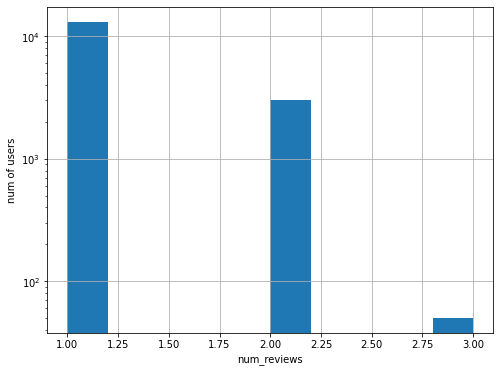

Пользователь оставляет от 1 до 3 отзывов. При этом в основном один пользователь оставляет не более 2ух


In [ ]:
print(df.user_id.unique().__len__())

plt.figure(figsize=(8, 6))
ax = df.groupby(['user_id'])['title'].count().hist()
plt.yscale('log')
plt.xlabel('num_reviews')
plt.ylabel('num of users')
plt.show() 

print('Пользователь оставляет от 1 до 3 отзывов. При этом в основном один пользователь оставляет не более 2ух')

Определим id для каждого аниме

In [ ]:
from sklearn.preprocessing import LabelEncoder

def preproc_title_func(title):
  return ' '.join([word.strip().strip('!') for word in  title.lower().strip().split()])
  

preprocessed_title = df.title.apply(preproc_title_func)
anime_title_encoder = LabelEncoder()
df['anime_id'] = anime_title_encoder.fit_transform(preprocessed_title)

Обработаем описание

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re



def preproc_description(description):
  # make more preprocessing if it well be needed!
  if isinstance(description, str):
      description = re.sub('[-+/\'.&*!]', '', description)
      return description.lower().strip()
  else:
    return ''

preprocessed_description = df.description.apply(preproc_description)

description_vectorizer = TfidfVectorizer()

embeddings = description_vectorizer.fit_transform(preprocessed_description)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

genre_onehot_enc = OneHotEncoder()

genres_set = set()
for genres in df.genre:
  genres_list = [i.strip("'").lower() for i in genres.strip('[]').split(', ')]
  for genre in genres_list:
    if genre != '':
      genres_set.add(genre)
  
genres_list = list(genres_set)
len(genres_list), genres_list

(43,
 ['cars',
  'yaoi',
  'samurai',
  'hentai',
  'action',
  'romance',
  'dementia',
  'psychological',
  'game',
  'music',
  'adventure',
  'josei',
  'sports',
  'school',
  'comedy',
  'fantasy',
  'military',
  'magic',
  'ecchi',
  'slice of life',
  'harem',
  'kids',
  'mystery',
  'shounen ai',
  'horror',
  'drama',
  'shoujo',
  'supernatural',
  'martial arts',
  'vampire',
  'shoujo ai',
  'sci-fi',
  'super power',
  'mecha',
  'historical',
  'police',
  'space',
  'parody',
  'shounen',
  'demons',
  'seinen',
  'thriller',
  'yuri'])

In [ ]:
from hashlib import md5

encoded_genre_matrix = []
for genres in df.genre:
  genres_list_in_row = [i.strip("'").lower() for i in genres.strip('[]').split(', ')]
  row = np.zeros(len(genres_list), dtype=np.int16)
  # print(genres_list_in_row)
  # print(genres_list)
  for enum, i in enumerate(genres_list):
    if i in genres_list_in_row:
      # print(i)
      row[enum] = 1
  # print(row)
  # break
  # print(genres_list, '\n')
  # print(row)
  encoded_genre_matrix.append(row)

hashes = []
for line in encoded_genre_matrix:
  hashed = md5((''.join([str(i) for i in line])).encode('utf-8'))
  hashes.append(hashed.hexdigest())

# encoded_genre_matrix = np.array(encoded_genre_matrix, dtype=np.int16)
# encoded_genre_matrix.shape

In [ ]:
df = pd.concat((df, pd.DataFrame(encoded_genre_matrix, columns=genres_list)), axis=1)
df['hashed_genre'] = hashes

In [ ]:
from_date_list = []
to_date_list = []

for date in df.aired:
  try:
    splited = date.split('to')
    # print(splited)
    if len(splited) == 2 and splited[1].strip() != '?':
      from_date = pd.to_datetime(splited[0])
      to_date = pd.to_datetime(splited[1])
      # print(from_date, to_date, 'first clause')
    else:
      from_date = pd.to_datetime(splited[0])
      to_date = 'None'
      # print(from_date, to_date, 'second clause')
    
    from_date_list.append(from_date)
    to_date_list.append(to_date)
  except Exception as err:
    from_date = 'None'
    to_date = 'None'
    from_date_list.append(from_date)
    to_date_list.append(to_date)
    # print(splited)
    # print(err)
    

from_date_list.__len__(), to_date_list.__len__()

df['from_date'] = pd.Series(from_date_list)
df['to_date'] = pd.Series(to_date_list)

In [ ]:
df_not_encoded = df.copy()

df.drop(columns=['title', 'description', 'genre', 'aired'], inplace=True)

In [ ]:
df

,user_id,num_episodes,members,popylarity_ind,rank,score,anime_id,cars,yaoi,samurai,hentai,action,romance,dementia,psychological,game,music,adventure,josei,sports,school,comedy,fantasy,military,magic,ecchi,slice of life,harem,kids,mystery,shounen ai,horror,drama,shoujo,supernatural,martial arts,vampire,shoujo ai,sci-fi,super power,mecha,historical,police,space,parody,shounen,demons,seinen,thriller,yuri,hashed_genre,from_date,to_date
0,28891,25.0,489888,141,25.0,8.82,4707,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,82ab6a0808e3247fc453204bd06cf571,2015-10-04 00:00:00,2016-03-27 00:00:00
1,23273,22.0,995473,28,24.0,8.83,12566,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,47176578041ccca93182502c80d987cc,2014-10-10 00:00:00,2015-03-20 00:00:00
2,34599,13.0,581663,98,23.0,8.83,8315,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,48f0f536bddee60d134a369047f34877,2017-07-07 00:00:00,2017-09-29 00:00:00
3,5114,64.0,1615084,4,1.0,9.23,3778,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,11accda6e47a33e20d1226ff85ea7893,2009-04-05 00:00:00,2010-07-04 00:00:00
4,31758,1.0,214621,502,22.0,8.83,7290,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,d98a646f345d96ae938f0d5600352d37,2017-01-06 00:00:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19306,32979,13.0,134252,843,1070.0,7.73,3666,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,e886c7890e9bbe9016ff31dab81f456e,2016-10-06 00:00:00,2016-12-29 00:00:00
19307,123,52.0,84407,1292,1071.0,7.73,3830,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,fc85442eebd535eec4326057a09a6a39,1995-04-06 00:00:00,1996-03-28 00:00:00
19308,1281,19.0,83093,1314,1073.0,7.73,3946,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,613cc1266ca438467e8ad47f2d2b7259,2000-10-22 00:00:00,2001-03-25 00:00:00
19309,450,1.0,71989,1469,1077.0,7.73,5981,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,972ec3b1ae02b9b13b85a3ba0bf5d643,2002-12-21 00:00:00,None


## Content based filtering (prediction similar anime) 

Now searching only at same ganres (full equality)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, genre_hash, X_ids, X_title, X_overview):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_overview - массив описаний объектов
        X_rank_matrix
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'description': pd.Series(X_overview, dtype='str'),
            'cos_sim': pd.Series([], dtype='float'),
             'genre_hash': pd.Series(genre_hash, dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, search_genre_hash, search_anime_id):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        search_genre_hash - хеш комбинации жанров искомого аниме для сопоставления
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
    
        # близость по описанию
        dist = cosine_similarity(self._X_matrix, X_matrix_object)
        self.df['cos_sim'] = dist * scale
        res = self.df
        # близость по жанрам
        # dist_genre = manhattan_distances(self._genre_matrix, genre_matrix_object)
        res = res[(res.genre_hash == search_genre_hash) & (res.cos_sim < scale)
         & (res.id != search_anime_id)]

        res.drop_duplicates(subset=['id'], inplace=True)
        # res = self.df
        res = res.sort_values(by=['cos_sim'], ascending=[False])
        # Не учитываем рекомендации с единичным расстоянием,
        # так как это искомый объект
        # также проверяем на полное совпадение жанров (TODO: учесть
        # в будущем возможность отсутствия полного совпадения)
        
      
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [ ]:
for id, i in zip(df_not_encoded.anime_id, df_not_encoded.title):
  if 'naruto' in i.lower():
    print(id, i)

df_not_encoded[df_not_encoded.anime_id == 9766]

9766 Naruto
9777 Naruto: Shippuuden
14212 The Last: Naruto the Movie
9785 Naruto: Shippuuden Movie 6 - Road to Ninja
6640 Kamiusagi Rope x Boruto: Naruto Next Generations
1575 Boruto: Naruto the Movie
9767 Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
9772 Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!
9766 Naruto
9784 Naruto: Shippuuden Movie 5 - Blood Prison
1576 Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi
9769 Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!
9768 Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!
9787 Naruto: The Cross Roads
9775 Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! - Konoha no Sato no Dai Undouaki
9770 Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jounin vs. Genin!! Musabetsu Dairansen Taikai Kaisai!!
9786 Naruto: Takigakure no Shitou - Ore ga Eiyuu Dattebayo!
9777 Naruto: Shippuuden
9783 Naruto: Shippuuden Movie 4 - The Lost Tower
9774 Naruto: A

,user_id,title,description,genre,aired,num_episodes,members,popylarity_ind,rank,score,anime_id,cars,yaoi,samurai,hentai,action,romance,dementia,psychological,game,music,adventure,josei,sports,school,comedy,fantasy,military,magic,ecchi,slice of life,harem,kids,mystery,shounen ai,horror,drama,shoujo,supernatural,martial arts,vampire,shoujo ai,sci-fi,super power,mecha,historical,police,space,parody,shounen,demons,seinen,thriller,yuri,hashed_genre,from_date,to_date,from_year
144,20,Naruto,"Moments prior to Naruto Uzumaki's birth, a hug...","['Action', 'Adventure', 'Comedy', 'Super Power...","Oct 3, 2002 to Feb 8, 2007",220.0,1280914,9,670.0,7.93,9766,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,20f573d51043450b0357dd159336bb3e,2002-10-03 00:00:00,2007-02-08 00:00:00,2002.0
5292,20,Naruto,"Moments prior to Naruto Uzumaki's birth, a hug...","['Action', 'Adventure', 'Comedy', 'Super Power...","Oct 3, 2002 to Feb 8, 2007",220.0,1280914,9,670.0,7.93,9766,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,20f573d51043450b0357dd159336bb3e,2002-10-03 00:00:00,2007-02-08 00:00:00,2002.0


In [ ]:
test_anime = df.iloc[5292]
test_anime

user_id                                         20
num_episodes                                   220
members                                    1280914
popylarity_ind                                   9
rank                                           670
score                                         7.93
anime_id                                      9766
cars                                             0
yaoi                                             0
samurai                                          0
hentai                                           0
action                                           1
romance                                          0
dementia                                         0
psychological                                    0
game                                             0
music                                            0
adventure                                        1
josei                                            0
sports                         

In [ ]:
recommender = SimpleKNNRecommender(embeddings, df.hashed_genre, df.anime_id,
                                   df_not_encoded.title, df_not_encoded.description)

rec1 = recommender.recommend_for_single_object(K=5,
                                               X_matrix_object=embeddings[test_anime.anime_id],
                                               search_genre_hash = test_anime.hashed_genre,
                                               search_anime_id = test_anime.anime_id)

print('Searching same as:', df_not_encoded[df_not_encoded.anime_id == test_anime.anime_id].title.iloc[0])

rec1.drop_duplicates(subset=['id'], inplace=True)
rec1[['id', 'title', 'description', 'cos_sim']]

Searching same as: Naruto


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,title,description,cos_sim
485,9777,Naruto: Shippuuden,It has been two and a half years since Naruto ...,39024.341592
13700,1573,Boruto: Jump Festa 2016 Special,The special anime adaptation of Boruto will be...,0.000000


## Collaborative filtering

In [ ]:
df_not_encoded['from_year'] = df_not_encoded.from_date.apply(lambda x: x.year if x != 'None' else None)

df_not_encoded.from_year

0        2015.0
1        2014.0
2        2017.0
3        2009.0
4        2017.0
          ...  
19306    2016.0
19307    1995.0
19308    2000.0
19309    2002.0
19310    1988.0
Name: from_year, Length: 19311, dtype: float64

In [ ]:
user_grouped_info = df_not_encoded.groupby(['user_id'], as_index=False).agg({'rank': np.mean, 'score': np.mean,
                                         'members': np.max, 'anime_id': 'count',
                                         'num_episodes': np.median,
                                         'from_year': np.min})

user_grouped_info.columns = ['user_id', 'rank', 'score', 'members', 'count_anime', 'num_episodes', 'from_year']

In [ ]:
user_grouped_info.isna().sum()

user_id            0
rank            1663
score            341
members            0
count_anime        0
num_episodes     492
from_year        273
dtype: int64

In [ ]:
user_grouped_info.dropna(subset=['score', 'num_episodes', 'from_year', 'rank'], inplace=True)
user_grouped_info.isna().sum()

user_id         0
rank            0
score           0
members         0
count_anime     0
num_episodes    0
from_year       0
dtype: int64

In [ ]:
user_grouped_finally = user_grouped_info[user_grouped_info.count_anime > 1]
user_grouped_finally.drop(columns=['count_anime'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

user_grouped_finally.iloc[:, 1:] = scaler.fit_transform(user_grouped_finally.iloc[:, 1:])
user_grouped_finally

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,user_id,rank,score,members,num_episodes,from_year
0,1,-0.097838,0.462687,5.409691,0.904762,-1.083333
1,5,-0.081216,0.258706,1.085813,-0.285714,-0.833333
2,6,-0.066757,0.199005,2.534706,0.904762,-1.083333
5,15,-0.028108,0.069652,0.496103,6.571429,-0.500000
6,16,-0.042432,0.114428,0.862603,0.809524,-0.500000
...,...,...,...,...,...,...
15919,40211,-0.027568,0.074627,-0.272007,-0.285714,0.666667
15944,40269,0.020541,-0.039801,-0.204058,0.238095,0.666667
15949,40286,0.967162,-0.875622,-0.278366,-0.285714,0.666667
16057,40480,0.962027,-0.870647,-0.276385,-0.285714,0.666667


In [ ]:
TEST_USER_INDEX = 1200

test_user = user_grouped_finally.iloc[TEST_USER_INDEX, 1:]
test_user_id = user_grouped_finally.iloc[TEST_USER_INDEX].user_id
test_user_titles = list(set(df_not_encoded[df_not_encoded.user_id == test_user_id].title))
print('test_user_id', test_user_id, '\n', 'test_user_titles', test_user_titles)


test_user_matrix = np.array(test_user).reshape(1, -1)
user_matrix = np.array(user_grouped_finally.iloc[:, 1:])
user_matrix.shape, user_matrix

user_grouped_finally['similarity'] = cosine_similarity(user_matrix, test_user_matrix)



test_user_id 33350.0 
 test_user_titles ['Zhen Hun Jie']


In [ ]:
user_grouped_finally = user_grouped_finally[user_grouped_finally.similarity < 1]
res = user_grouped_finally.sort_values(by=['similarity'], ascending=False)

def get_searched_anime(df, searching_user_id):
  return df[df.user_id == searching_user_id]

def get_other_anime(df, user_id, viewed_animes_list):
  res_titles = []
  recommended_user_titles = list(set(df[df.user_id == user_id].title))
  for title in recommended_user_titles:
    if title not in viewed_animes_list:
      res_titles.append(title)
  return res_titles


searched_animes = list(set(get_searched_anime(df_not_encoded, res.iloc[TEST_USER_INDEX].user_id).title))


res = get_other_anime(df_not_encoded, res.iloc[0].user_id, searched_animes)

res

['Uchuu Senkan Yamato 2202: Ai no Senshi-tachi']